In [1]:
import copy
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

# Import data

In [2]:
# Import retail data
cost_matrix = np.loadtxt('../data/input/retail/cost_matrix.txt')
origin_supply = np.loadtxt('../data/input/retail/origin_supply.txt')
initial_destination_sizes = np.loadtxt('../data/input/retail/initial_destination_sizes.txt')
rsquared_analysis = np.loadtxt("../cities_and_regions/output/rsquared_analysis.txt")

N,M = cost_matrix.shape

In [3]:
np.sum(origin_supply)

1.0

In [4]:
np.max(rsquared_analysis)

0.9019837895702899

In [5]:
0.3/M

0.006122448979591836

In [6]:
np.min(initial_destination_sizes)

0.00617494255748621

In [7]:
np.sum(initial_destination_sizes)

1.0

In [66]:
np.sum(cost_matrix)

1.0

In [67]:
np.max(cost_matrix)

0.00012041250708713227

In [68]:
np.min(cost_matrix)

0.0

In [90]:
beta = 28000

In [91]:
np.min(np.exp(-cost_matrix*beta))

0.03433636788110734

In [92]:
np.max(np.exp(-cost_matrix*beta))

1.0

# Retail data

## Import retail data

In [15]:
data = np.loadtxt("../cities_and_regions/data/london_n/shopping_small.txt")
popn = np.loadtxt("../cities_and_regions/data/london_n/popn.txt")
retail_wd0 = np.exp(np.loadtxt("../cities_and_regions/data/london_n/xd0.txt"))
retail_orig_supply = popn[:, 2]/popn[:, 2].sum()
ret_locs = data[:, [0, 1]]
res_locs = popn[:, [0, 1]]

## Plot retail data

In [19]:
# Set plot params
latent_factor = 1000
actual_factor = 10000

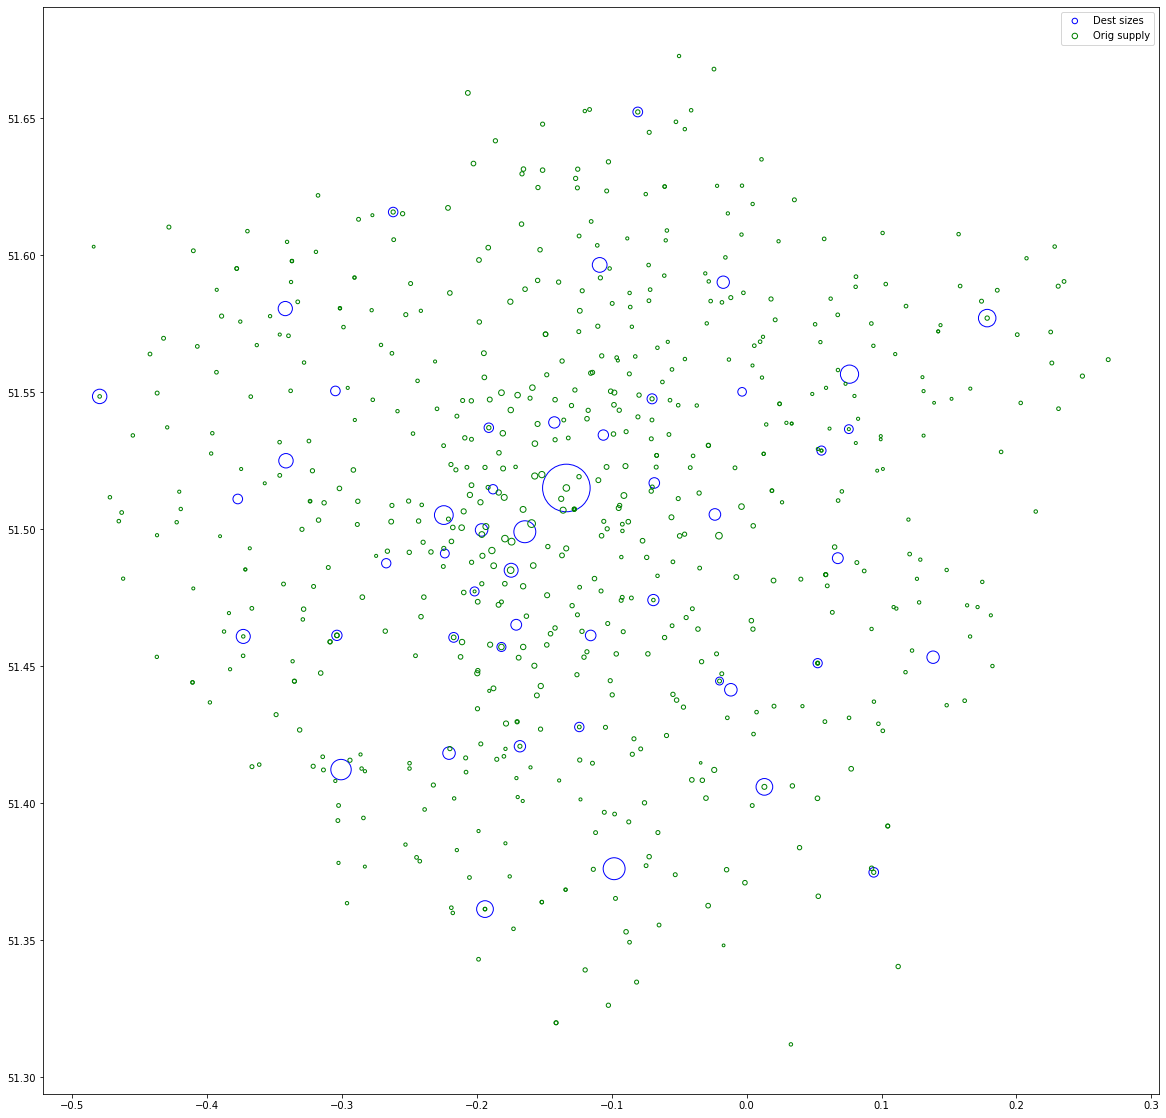

In [20]:
plt.figure(figsize=(20,20))
plt.scatter(ret_locs[:, 1], ret_locs[:, 0], facecolor="None",edgecolors='b', s=actual_factor*retail_wd0, alpha=1,label='Dest sizes')
plt.scatter(res_locs[:, 1], res_locs[:, 0], facecolor="None",edgecolors='g', s=actual_factor*retail_orig_supply, alpha=1,label='Orig supply')
# Plot legend.
lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=10)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]